In [1]:
import pandas as pd
import numpy as np
import time
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import networkx as nx
from node2vec import Node2Vec
import random

In [2]:
spark = SparkSession.builder.appName("test").getOrCreate()

In [3]:
# import data
from pyspark.sql.functions import mean
block = spark.read.csv("block.csv",header=True)
block = block.withColumn('numint',col('num').cast("int"))
med = int(block.select(mean('numint')).collect()[0].__getitem__('avg(numint)'))

In [5]:
# import transaction data
data = spark.read.csv("transaction.csv",header=True)
print(data.count())
# filter data
data = data.filter(data.block_num<='5360000')
data = data.withColumn('amountv',col('amount').cast("double"))
mdf = data.groupBy("from_addr","to_addr","block_num").avg( "amountv" )
print(mdf.count())

10779107
69246


In [6]:
# generate edge list
from_addr = [row[0] for row in mdf.select('from_addr').collect()]
to_addr = [row[0] for row in mdf.select('to_addr').collect()]
avgamount = [row[0] for row in mdf.select('avg(amountv)').collect()]
testdf = pd.DataFrame({'from_addr':from_addr,'to_addr':to_addr,'avgamount':avgamount})

In [7]:
# generate node list
nodes_dict = sorted(set(testdf['from_addr'].tolist()).union(set(testdf['to_addr'].tolist())))
# map between node id to addr
addr2id = {v:str(k) for k,v in enumerate(nodes_dict)}
id2addr = {v:k for k,v in addr2id.items()}

In [8]:
# change addr to node id
testdf['from_id'] = testdf['from_addr'].apply(lambda x:addr2id[x])
testdf['to_id'] = testdf['to_addr'].apply(lambda x:addr2id[x])

In [135]:
# number of nodes
nodenum = len(addr2id)
print(nodenum)

59779


In [12]:
# generate graph
edgelist = testdf[['from_id','to_id','avgamount']].values.tolist()
graph = nx.DiGraph()
graph.add_weighted_edges_from(edgelist)

In [13]:
# extract node embeddings using node2vec
a = time.time()
# Precompute probabilities and generate walks
node2vec = Node2Vec(graph, dimensions=8, walk_length=30, num_walks=30, workers=2)  
# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  
print(time.time()-a)

Computing transition probabilities:   0%|          | 0/59779 [00:00<?, ?it/s]

437.51295590400696


In [14]:
# node embeddings
embed = model.wv.vectors

In [25]:
# normalize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
norm_embed = scaler.fit_transform(embed)

In [104]:
# k-means cluster based on node embeddings
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k, random_state=0) 
kmeans.fit(norm_embed)

KMeans(n_clusters=5, random_state=0)

In [127]:
from collections import Counter
count = sorted(Counter(kmeans.labels_).items())

[(0, 36435), (1, 4335), (2, 5629), (3, 681), (4, 12699)]

In [107]:
# cluster results
y_kmeans = kmeans.predict(norm_embed)

In [109]:
# tsne Reduction for visualization
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,random_state=1, n_iter=1000, metric="cosine")
embs = tsne.fit_transform(norm_embed)

E:\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


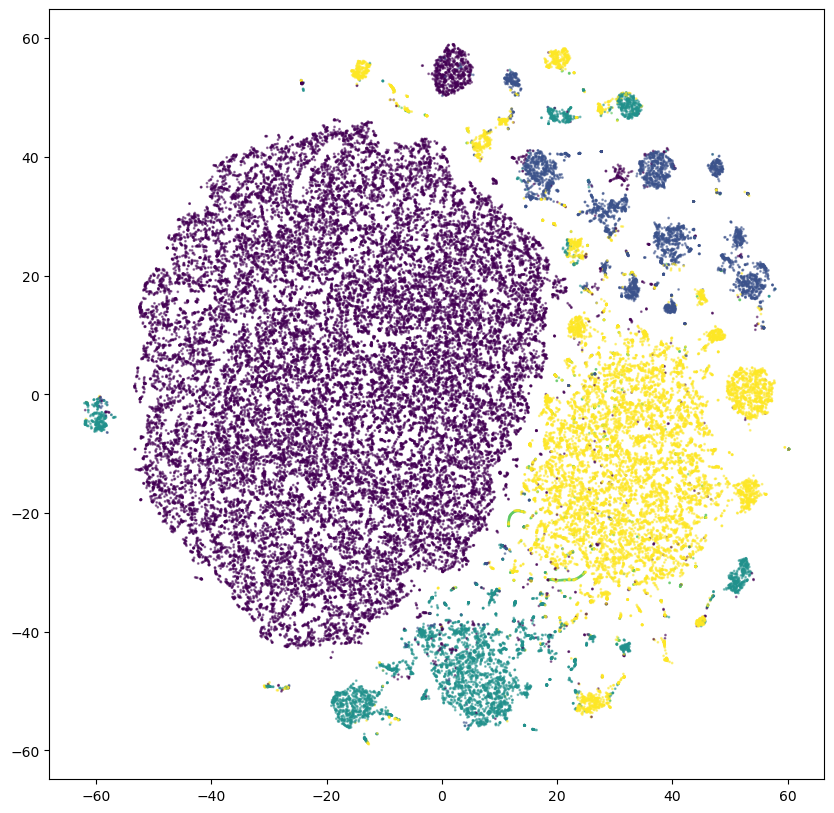

In [136]:
# plot of embeddings
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(10,10))
plt.scatter(embs[:, 0], embs[:, 1], c=y_kmeans, s=1, alpha=0.5, cmap='viridis')
#plt.title('Visualization of Address Embeddings using t-SNE Reduction')
figure.savefig('emb_tsne.jpg')
figure

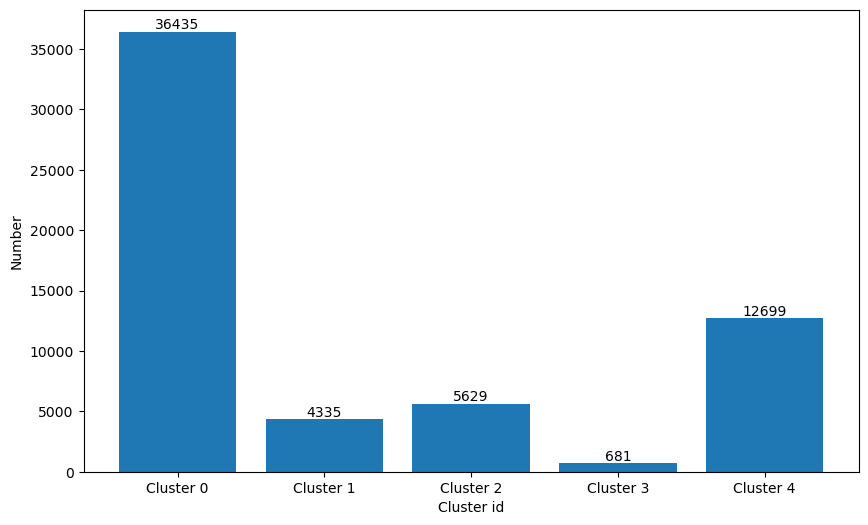

In [137]:
# plot of cluster
names = ["Cluster "+str(x[0]) for x in count]
values = [x[1] for x in count]

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(names, values)
ax.bar_label(bars)
plt.xlabel('Cluster id')
plt.ylabel('Number')
#plt.title('Cluster Result Based on Node Embeddings')
fig.savefig("emb_cluster.jpg")
fig